In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

# 使わない場合は省く
import slack_notification as sn

In [2]:
%matplotlib inline

In [3]:
"""
今のフォルダ構成
airbus 
|--FusionNet.ipynb
|--fusionnet_mse_loss
|--model_fusion
|--model_fusion_state
|--model_unet
|--model_unet_0803
|--result_fusion
|--result_unet
|--result_unet_0803
|--slack_notification.py
|--submission_0802.csv
|--submission_0803.csv
|--submission_fusion.csv
|--test
|--train
|--train_ship_segmentations.csv
|--unet_4_1600.pkl
|--unet.ipynb
|--unet_mse_loss
|--unet_mse_loss_
"""

'\n今のフォルダ構成\nairbus \n|--FusionNet.ipynb\n|--fusionnet_mse_loss\n|--model_fusion\n|--model_fusion_state\n|--model_unet\n|--model_unet_0803\n|--result_fusion\n|--result_unet\n|--result_unet_0803\n|--slack_notification.py\n|--submission_0802.csv\n|--submission_0803.csv\n|--submission_fusion.csv\n|--test\n|--train\n|--train_ship_segmentations.csv\n|--unet_4_1600.pkl\n|--unet.ipynb\n|--unet_mse_loss\n|--unet_mse_loss_\n'

# Preprocessing

In [4]:
masks  =  pd.read_csv ('./train_ship_segmentations.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [5]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
"""
ランレングス記法のデータを白黒画像に直す
"""
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    #nan check
    if mask_rle != mask_rle:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        return img.reshape(shape).T
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [6]:
"""
trainの画像の教師画像を作る
"""
def create_mask(image_path):
    img_masks = masks.loc[masks['ImageId'] == image_path.split('/')[-1], 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    masks_all = np.zeros((768, 768))
    for mask in img_masks:
        masks_all += rle_decode(mask)
    masks_all = np.minimum(masks_all, 1)*255
    tmp = np.array((masks_all, masks_all, masks_all), dtype=np.uint8)
    tmp = tmp.transpose(1,2,0)
    
    return tmp

In [7]:
"""
白黒画像をランレングス記法にする
"""
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
def convert_runlength(convert_image):
    convert_image = cv2.resize(convert_image, (768, 768))
    flatten = np.where((convert_image.T).flatten() == 1)[0]
    runlength = ""
    count = 0
    if len(flatten) == 1:
        runlength = str(flatten[0]) + " 1"
        return runlength
    for i in range(len(flatten)):
        if i == 0:
            runlength = runlength +  str(flatten[i]) + " "
            count = 1
        elif i == len(flatten)-1:
            if flatten[i] == flatten[i-1]+1:
                count += 1
                runlength = runlength + str(count)
            else:
                runlength = runlength + str(count) + " " + str(flatten[i]) + " 1"
        else:
            if flatten[i] == flatten[i-1]+1:
                count += 1
            else:
                runlength = runlength + str(count) + " " + str(flatten[i]) + " "
                count = 1
    return runlength

## demo

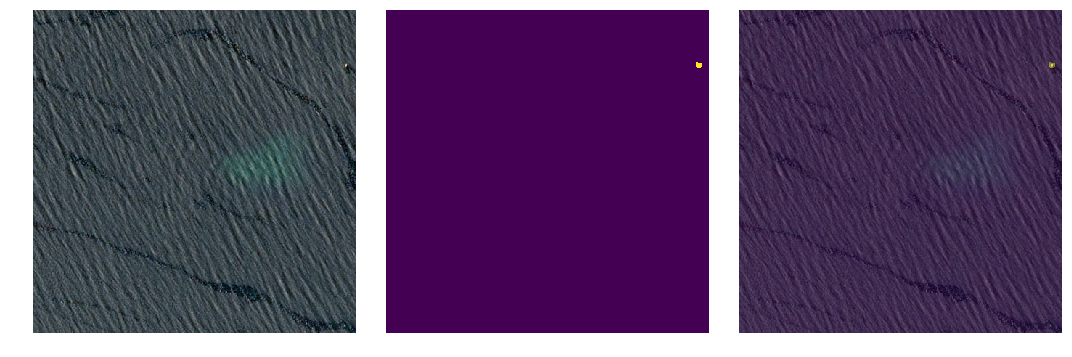

In [9]:
ImageId = '00053c6ba.jpg'

img = cv2.imread('./train/' + ImageId)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)
    
all_masks = np.minimum(all_masks, 1)
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()


# Make Dataset

In [10]:
"""
train用のデータセット
"""
class AirbusDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masked_img = create_mask(image_path)
        if self.transform:
            image = self.transform(image)
            masked_img = self.transform(masked_img)
        return image, masked_img

In [11]:
#バッチサイズ16以上だと、メモリ30GBではメモリが足りなくなる
batch_size = 8
img_size = 256

In [12]:
train_dataset = AirbusDataset(root_dir='./train/', transform=transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.Resize(size=img_size),
                                            transforms.ToTensor(),
                                            ]))
train_batch = data.DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)

# Make Network

In [13]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model    


def conv_block_3(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        conv_block(out_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

In [14]:
class UnetGenerator(nn.Module):

	def __init__(self,in_dim,out_dim,num_filter):
		super(UnetGenerator,self).__init__()
		self.in_dim = in_dim
		self.out_dim = out_dim
		self.num_filter = num_filter
		act_fn = nn.LeakyReLU(0.2, inplace=True)

		print("\n------Initiating U-Net------\n")

		self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
		self.pool_1 = maxpool()
		self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
		self.pool_2 = maxpool()
		self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
		self.pool_3 = maxpool()
		self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
		self.pool_4 = maxpool()

		self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

		self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
		self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
		self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
		self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
		self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
		self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
		self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
		self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

		self.out = nn.Sequential(
			nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
			nn.Tanh(),
		)

	def forward(self,input):
		down_1 = self.down_1(input)
		pool_1 = self.pool_1(down_1)
		down_2 = self.down_2(pool_1)
		pool_2 = self.pool_2(down_2)
		down_3 = self.down_3(pool_2)
		pool_3 = self.pool_3(down_3)
		down_4 = self.down_4(pool_3)
		pool_4 = self.pool_4(down_4)

		bridge = self.bridge(pool_4)

		trans_1 = self.trans_1(bridge)
		concat_1 = torch.cat([trans_1,down_4],dim=1)
		up_1 = self.up_1(concat_1)
		trans_2 = self.trans_2(up_1)
		concat_2 = torch.cat([trans_2,down_3],dim=1)
		up_2 = self.up_2(concat_2)
		trans_3 = self.trans_3(up_2)
		concat_3 = torch.cat([trans_3,down_2],dim=1)
		up_3 = self.up_3(concat_3)
		trans_4 = self.trans_4(up_3)
		concat_4 = torch.cat([trans_4,down_1],dim=1)
		up_4 = self.up_4(concat_4)

		out = self.out(up_4)

		return out

In [15]:
def iou(img_true, img_pred):
    #img_true = img_true.transpose(0,2).transpose(0,1)
    #img_pred = img_pred.transpose(0,2).transpose(0,1)
    #img_true = img_true.mean(dim=2)
    #img_pred = img_pred.mean(dim=2)
    i = torch.sum((img_true*img_pred) >0)
    u = torch.sum((img_true + img_pred) >0) + 0.0000001  # avoid division by zero
    return i/u

class IouLoss(nn.Module):
    def __init__(self):
        super(IouLoss, self).__init__()  
    
    def forward(self, input, target):
        _sum = torch.sum(torch.Tensor([iou(target[i], input[i]) for i in range(batch_size)]))/batch_size
        return Variable(torch.FloatTensor(np.array([_sum])), requires_grad=True)

In [ ]:
#空のモデルから学習する時
#recon_loss_func = nn.MSELoss()
recon_loss_func = IouLoss()
generator = nn.DataParallel(UnetGenerator(3,3,64),device_ids=[0]).cuda()

lr = 0.001
gen_optimizer = torch.optim.Adam(generator.parameters(),lr=lr)


------Initiating U-Net------



# Training

In [ ]:
epoch = 10
file = open('./unet_iou_loss', 'w')
losses = []
for i in range(epoch):
    for _, (images,img_masks) in enumerate(train_batch):
        gen_optimizer.zero_grad()

        x = Variable(images).cuda(0)
        y_ = Variable(img_masks).cuda(0).float()
        y = generator.forward(x)
        
        loss = recon_loss_func(y.cpu().data, y_.cpu().data)
        file.write(str(loss)+"\n")
        loss.backward()
        gen_optimizer.step()
        losses.append(loss.data[0])

        if _ % 400 ==0:
            print(i)
            print(loss)
            losses_np = np.asarray(losses)
            batches = np.array([i for i in range(len(losses_np))])
            plt.plot(batches, losses_np)
            plt.ylabel("loss")
            plt.xlabel("batch")
            plt.savefig('./model_unet_iou/loss.png')
            
            v_utils.save_image(x.cpu().data,"./result_unet_iou/original_image_{}_{}.png".format(i,_))
            v_utils.save_image(y_.cpu().data,"./result_unet_iou/label_image_{}_{}.png".format(i,_))
            v_utils.save_image(y.cpu().data,"./result_unet_iou/gen_image_{}_{}.png".format(i,_))
            torch.save(generator,'./model_unet_iou/unet_newest')    
            
            # 使わない場合は省く
            sn.send_notification(text = 'finish: epoch {}, batch_idx {}'.format(i,_))
            sn.upload_image(image='./model_unet_iou/loss.png')
        if _ % 1000 ==0:
            torch.save(generator.state_dict(), './model_unet_iou/unet_{}_{}_state.pkl'.format(i,_))

0
Variable containing:
1.00000e-03 *
  1.7108
[torch.FloatTensor of size 1]



/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type UnetGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0
Variable containing:
1.00000e-03 *
  4.3882
[torch.FloatTensor of size 1]



In [ ]:
a = np.array([[[1],[2]], [[3],[4]], [[5],[6]]])

In [40]:
a_t = torch.FloatTensor(a)

In [41]:
a_t.size()

torch.Size([3, 2, 1])

In [46]:
a_t.transpose(0,2).transpose(0,1)


(0 ,.,.) = 
  1  3  5

(1 ,.,.) = 
  2  4  6
[torch.FloatTensor of size 2x1x3]

In [25]:
torch.mean(a_t, axis=1)

TypeError: torch.mean received an invalid combination of arguments - got (torch.FloatTensor, axis=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, int dim)
      didn't match because some of the keywords were incorrect: axis
 * (torch.FloatTensor source, int dim, bool keepdim)


# evaluation

evaluationだけする場合もUnetクラスを実行する必要あり

In [11]:
"""
test用データセット
"""
class AirbusTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

In [12]:
test_dataset = AirbusTestDataset(root_dir='./test/', transform=transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.Resize(size=img_size),
                                            transforms.ToTensor()
                                            ]))
test_batch = data.DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [13]:
#学習済みモデルをロード
model = torch.load("./model_unet_0811_2/unet_newest.pkl")

In [14]:
"""
test_batchの中の最初の画像でテスト
"""
def test_sample(th=0.5):
    count = 0
    for _, (image, image_paths) in enumerate(test_batch):
        if count >= 1:
            break
        count += 1
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        out_img = outputs[0].transpose(1,2,0)
        out_img = np.maximum(out_img, 0)
        out_img = np.minimum(out_img, 1)
        out_gray = np.mean(out_img, axis=2)
        
        max_pixel = 1
        _, out_thresh = cv2.threshold(out_gray, th, max_pixel, cv2.THRESH_BINARY)
        
        out_thresh = cv2.resize(out_thresh, (768, 768))
        rl = rle_encode(out_thresh)
        decoded_img = rle_decode(rl)
        print(np.max(out_gray))
        print(rl)
        
        
        original_img = cv2.imread('./test/{}'.format(image_paths[0]))
        fig, axarr = plt.subplots(1, 4, figsize=(15, 40))
        plt.gray()
        axarr[0].imshow(out_gray)
        axarr[1].imshow(out_thresh)
        axarr[2].imshow(original_img)
        plt.gray()
        axarr[3].imshow(decoded_img)
        plt.tight_layout(h_pad=0.1, w_pad=0.1)
        plt.show()

In [15]:
"""
test_batchの中で、モデルを通して白い部分が現れるものが出てくるまで繰り返す
"""
def test_sample2(th=0.5):
    count = 0
    for _, (image, image_paths) in enumerate(test_batch):
        if count >= 1:
            break
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        out_img = outputs[0].transpose(1,2,0)
        out_img = np.maximum(out_img, 0)
        out_img = np.minimum(out_img, 1)
        out_gray = np.mean(out_img, axis=2)
        
        max_pixel = 1
        _, out_thresh = cv2.threshold(out_gray, th, max_pixel, cv2.THRESH_BINARY)
        
        out_thresh = cv2.resize(out_thresh, (768, 768))
        #rl = rle_encode(out_thresh)
        rl = convert_runlength(out_thresh)
        if rl != "":
            count += 1
            decoded_img = rle_decode(rl)
            print(np.max(out_gray))
            print(rl)
        
        
            original_img = cv2.imread('./test/{}'.format(image_paths[0]))
            fig, axarr = plt.subplots(1, 4, figsize=(15, 40))
            plt.gray()
            axarr[0].imshow(out_gray)
            axarr[1].imshow(out_thresh)
            axarr[2].imshow(original_img)
            plt.gray()
            axarr[3].imshow(decoded_img)
            plt.tight_layout(h_pad=0.1, w_pad=0.1)
            plt.show()
        

In [16]:
def test_sample3():
    count = 0
    for _, (image, image_paths) in enumerate(test_batch):
        if count >= 1:
            break
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        out_img = outputs[0].transpose(1,2,0)
        out_img = np.maximum(out_img, 0)
        out_img = np.minimum(out_img, 1)
        out_gray = np.mean(out_img, axis=2)
        
        max_pixel = 1
        if np.max(out_gray) >= 0.7:
            thresh = 0.21
        else:
            thresh = 0.6
        _, out_thresh = cv2.threshold(out_gray, thresh, max_pixel, cv2.THRESH_BINARY)
        
        out_thresh = cv2.resize(out_thresh, (768, 768))
        rl = convert_runlength(out_thresh)
        if rl != "":
            count += 1
            decoded_img = rle_decode(rl)
            print(rl)
        
        
            original_img = cv2.imread('./test/{}'.format(image_paths[0]))
            fig, axarr = plt.subplots(1, 4, figsize=(15, 40))
            plt.gray()
            axarr[0].imshow(out_gray)
            axarr[1].imshow(out_thresh)
            axarr[2].imshow(original_img)
            plt.gray()
            axarr[3].imshow(decoded_img)
            plt.tight_layout(h_pad=0.1, w_pad=0.1)
            plt.show()
        

0.996599
464065 13 464833 13 465601 13 466369 16 467137 16 467905 16 468673 16 469441 16 470209 16 470974 22 471742 22 472510 22 473278 22 474049 19 474817 19 475585 19 476353 19 477121 19 477889 19 478657 16 479425 16 480193 16 480964 10 481732 10 482500 10 503251 1 504019 1 504787 1 505549 10 506317 10 507085 10 507853 13 508621 13 509389 13 510157 13 510925 13 511693 13 512461 16 513229 16 513997 16 514765 16 515533 16 516301 16 517069 16 517840 13 518608 13 519376 16 520147 13 520915 13 521683 13 522451 13 523219 13 523987 13 524761 4 525529 4 526297 4


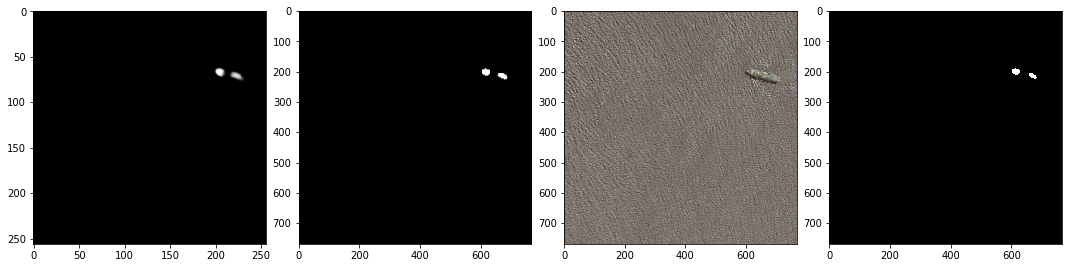

In [17]:
test_sample2(0.5)

In [ ]:
test_sample3()

In [18]:
#kaggleのページに書いてあった、無視すべき画像
ignore_images = ['13703f040.jpg',
                 '14715c06d.jpg',
                 '33e0ff2d5.jpg',
                 '4d4e09f2a.jpg',
                 '877691df8.jpg',
                 '8b909bb20.jpg',
                 'a8d99130e.jpg',
                 'ad55c3143.jpg',
                 'c8260c541.jpg',
                 'd6c7f17c7.jpg',
                 'dc3e7c901.jpg',
                 'e44dffe88.jpg',
                 'ef87bad36.jpg',
                 'f083256d8.jpg']

In [47]:
"""
テスト画像から、submissionのcsvを作る
"""
def test(th1, th2):
    index = 0
    count1 = 0
    count2 = 0
    df = pd.DataFrame({'ImageId': [], 'EncodedPixels1': [], 'EncodedPixels2': []})
    df = df[['ImageId', 'EncodedPixels1', 'EncodedPixels2']]
    
    for _, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        for img_name, out_img in zip(image_paths, outputs):
            if img_name in ignore_images:
                continue
            out_img = out_img.transpose(1,2,0)
            out_img = np.maximum(out_img, 0)
            out_img = np.minimum(out_img, 1)
            out_gray = np.mean(out_img, axis=2)
        
            max_pixel = 1
            _, out_thresh1 = cv2.threshold(out_gray, th1, max_pixel, cv2.THRESH_BINARY)
            _, out_thresh2 = cv2.threshold(out_gray, th2, max_pixel, cv2.THRESH_BINARY)
        
            out_thresh1 = cv2.resize(out_thresh1, (768, 768))
            rl1 = rle_encode(out_thresh1)
            if rl1 != "":
                count1 += 1
            
            out_thresh2 = cv2.resize(out_thresh2, (768, 768))
            rl2 = rle_encode(out_thresh2)
            if rl2 != "":
                count2 += 1
            
            df.loc[index] = [img_name, rl1, rl2]
            if index % 5000 == 0:
                df.to_csv('submission_0804_{}.csv'.format(th1), header=True, index=False, columns=['ImageId', 'EncodedPixels1'])
                df.to_csv('submission_0804_{}.csv'.format(th2), header=True, index=False, columns=['ImageId', 'EncodedPixels2'])

                # 使わない場合は省く
                if index == 0:
                    sn.send_notification(text='{} tests done, th1: {}, th2: {}'.format(index, count1, count2))
                else:
                    sn.send_notification(text='{} tests done, th1: {}, th2: {}'.format(index, count1/index, count2/index))
            index += 1
            
    df.to_csv('submission_0804_{}.csv'.format(th1), header=True, index=False, columns=['ImageId', 'EncodedPixels1'])
    df.to_csv('submission_0804_{}.csv'.format(th2), header=True, index=False, columns=['ImageId', 'EncodedPixels2'])
    # 使わない場合は省く
    sn.send_notification(text='all done')

In [48]:
test(th1=0.5, th2=0.7)

In [14]:
def  approximate_img(_img, eps):
    _, contours, _ = cv2.findContours(_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros_like(_img)
    for cnt in contours:
        epsilon = eps*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        result_img = cv2.fillConvexPoly(result_img, approx, 1)
    return result_img

def  approximate_img2(_img):
    _, contours, _ = cv2.findContours(_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros_like(_img)
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        result_img = cv2.fillConvexPoly(result_img, box, 1)
    return result_img

In [85]:
def test2():
    index = 0
    index1 = 0
    index2 = 0
    index3 = 0
    df1 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df1 = df1[['ImageId', 'EncodedPixels']]
    df2 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df2 = df2[['ImageId', 'EncodedPixels']]
    df3 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df3 = df3[['ImageId', 'EncodedPixels']]
    
    for ind, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        for img_name, out_img in zip(image_paths, outputs):
            if img_name in ignore_images:
                continue
            out_img = out_img.transpose(1,2,0)
            out_img = np.maximum(out_img, 0)
            out_img = np.minimum(out_img, 1)
            out_gray = np.mean(out_img, axis=2)
        
            max_pixel = 1
            if np.max(out_gray) >= 0.7:
                thresh1 = 0.201
                thresh2 = 0.3
            else:
                thresh1 = 0.6
                thresh2 = 0.6
            
            if np.max(out_gray) >= 0.5:
                thresh3 = 0.2
            else:
                thresh3 = 0.5
                
            max_pixel = 1
            out_gray = cv2.resize(out_gray, (768, 768))
                        
            _, out_thresh1 = cv2.threshold(out_gray, thresh1, max_pixel, cv2.THRESH_BINARY)
            out_thresh1 = np.array(out_thresh1, dtype='uint8')
            labels_num1, labeled_img1 = cv2.connectedComponents(out_thresh1)
            if labels_num1 <= 1:
                df1.loc[index1] = [img_name, '']
                index1 += 1
            else:
                for j in range(1, labels_num1):
                    separate = np.zeros((768, 768))
                    separate[labeled_img1 == j] = 1
                    rl = convert_runlength(separate)
                    df1.loc[index1] = [img_name, rl]
                    index1 += 1

            _, out_thresh2 = cv2.threshold(out_gray, thresh2, max_pixel, cv2.THRESH_BINARY)
            out_thresh2 = np.array(out_thresh2, dtype='uint8')
            labels_num2, labeled_img2 = cv2.connectedComponents(out_thresh2)
            if labels_num2 <= 1:
                df2.loc[index2] = [img_name, '']
                index2 += 1
            else:
                for j in range(1, labels_num2):
                    separate = np.zeros((768, 768))
                    separate[labeled_img2 == j] = 1
                    rl = convert_runlength(separate)
                    df2.loc[index2] = [img_name, rl]
                    index2 += 1

            _, out_thresh3 = cv2.threshold(out_gray, thresh3, max_pixel, cv2.THRESH_BINARY)
            out_thresh3 = np.array(out_thresh3, dtype='uint8')
            labels_num3, labeled_img3 = cv2.connectedComponents(out_thresh3)
            
            if labels_num3 <= 1:
                df3.loc[index3] = [img_name, '']
                index3 += 1
            else:
                for j in range(1, labels_num3):
                    separate = np.zeros((768, 768))
                    separate[labeled_img3 == j] = 1
                    rl = convert_runlength(separate)
                    df3.loc[index3] = [img_name, rl]
                    index3 += 1

            
        if ind % 300 == 0:
            df1.to_csv('submission_0813_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df2.to_csv('submission_0813_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df3.to_csv('submission_0813_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            sn.send_notification(text='{} tests done'.format(ind*batch_size))
            
    df1.to_csv('submission_0813_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df2.to_csv('submission_0813_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df3.to_csv('submission_0813_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    # 使わない場合は省く
    sn.send_notification(text='all done')

In [19]:
def test3():
    index = 0
    index1 = 0
    index2 = 0
    index3 = 0
    df1 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df1 = df1[['ImageId', 'EncodedPixels']]
    df2 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df2 = df2[['ImageId', 'EncodedPixels']]
    df3 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df3 = df3[['ImageId', 'EncodedPixels']]
    
    for ind, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        for img_name, out_img in zip(image_paths, outputs):
            if img_name in ignore_images:
                continue
            out_img = out_img.transpose(1,2,0)
            out_img = np.maximum(out_img, 0)
            out_img = np.minimum(out_img, 1)
            out_gray = np.mean(out_img, axis=2)
        
            max_pixel = 1
            if np.max(out_gray) >= 0.7:
                thresh1 = 0.201
                thresh2 = 0.3
            else:
                thresh1 = 0.6
                thresh2 = 0.6
            
            if np.max(out_gray) >= 0.5:
                thresh3 = 0.2
            else:
                thresh3 = 0.5
                
            max_pixel = 1
            out_gray = cv2.resize(out_gray, (768, 768))
                        
            _, out_thresh1 = cv2.threshold(out_gray, thresh1, max_pixel, cv2.THRESH_BINARY)
            rl1 = convert_runlength(out_thresh1)
            df1.loc[index] = [img_name, rl1]

            _, out_thresh2 = cv2.threshold(out_gray, thresh2, max_pixel, cv2.THRESH_BINARY)
            rl2 = convert_runlength(out_thresh2)
            df2.loc[index] = [img_name, rl2]

            _, out_thresh3 = cv2.threshold(out_gray, thresh3, max_pixel, cv2.THRESH_BINARY)
            rl3 = convert_runlength(out_thresh3)
            df3.loc[index] = [img_name, rl3]
            
            index += 1

            
        if ind % 300 == 0:
            df1.to_csv('submission_0816_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df2.to_csv('submission_0816_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df3.to_csv('submission_0816_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            sn.send_notification(text='{} tests done'.format(ind*batch_size))
            
    df1.to_csv('submission_0816_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df2.to_csv('submission_0816_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df3.to_csv('submission_0816_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    # 使わない場合は省く
    sn.send_notification(text='all done')

In [20]:
test3()

# Re-training

学習済みモデルをさらに学習させる

In [13]:
recon_loss_func = nn.L1Loss()
generator = torch.load('./model_unet_0811/unet_newest.pkl')

lr = 0.0005
gen_optimizer = torch.optim.Adam(generator.parameters(),lr=lr)

In [ ]:
epoch = 10
file = open('./unet_l1_loss_0811_2', 'w')
losses = []
for i in range(epoch):
    for _, (images,img_masks) in enumerate(train_batch):
        gen_optimizer.zero_grad()

        x = Variable(images).cuda(0)
        y_ = Variable(img_masks).cuda(0).float()
        y = generator.forward(x)
        
        loss = recon_loss_func(y,y_)
        file.write(str(loss)+"\n")
        loss.backward()
        gen_optimizer.step()
        losses.append(loss.data[0])
        if _ % 400 ==0:
            print(i)
            print(loss)
            losses_np = np.asarray(losses)
            batches = np.array([i for i in range(len(losses_np))])
            plt.plot(batches, losses_np)
            plt.ylabel("loss")
            plt.xlabel("batch")
            plt.savefig('./model_unet_0811_2/loss.png')
            v_utils.save_image(x.cpu().data,"./result_unet_0811_2/original_image_{}_{}.png".format(i,_))
            v_utils.save_image(y_.cpu().data,"./result_unet_0811_2/label_image_{}_{}.png".format(i,_))
            v_utils.save_image(y.cpu().data,"./result_unet_0811_2/gen_image_{}_{}.png".format(i,_))
            torch.save(generator,'./model_unet_0811_2/unet_newest.pkl')    
            # 使わない場合は省く
            sn.send_notification(text = 'finish: epoch {}, batch_idx {}, loss: {}'.format(i,_,loss))
            sn.upload_image(image='./model_unet_0811_2/loss.png')
        if _ % 1000 ==0:
            torch.save(generator.state_dict(), './model_unet_0811_2/unet_{}_{}_state.pkl'.format(i,_))


0
Variable containing:
1.00000e-03 *
  1.6470
[torch.cuda.FloatTensor of size 1 (GPU 0)]



/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type UnetGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0
Variable containing:
1.00000e-03 *
  1.9022
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-03 *
  1.4211
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  4.1262
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  3.9043
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-03 *
  1.7071
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  8.3593
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-03 *
  1.2239
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-03 *
  1.0253
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-04 *
  8.7560
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-03 *
  1.1816
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable containing:
1.00000e-03 *
  1.4786
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0
Variable

# Make Validation Dataset

In [25]:
"""
validation用のデータセット
"""
class AirbusValDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

In [26]:
val_dataset = AirbusValDataset(root_dir='./train/', transform=transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.Resize(size=img_size),
                                            transforms.ToTensor(),
                                            ]))
val_batch = data.DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [22]:
model = torch.load("./model_unet_0804/unet_newest.pkl")

In [69]:
for batch_index, (images, image_paths) in enumerate(val_batch):
    print(batch_index)
    if batch_index >= 200:
        break
    images = Variable(images)
    outputs = (model(images).data).cpu().numpy()
    for (out_img, img_name) in zip(outputs, image_paths):
        out_img = out_img.transpose(1,2,0)
        out_img = np.maximum(out_img, 0)
        out_img = np.minimum(out_img, 1)
        out_gray = np.mean(out_img, axis=2) * 255
        masked_img = create_mask('./train/{}'.format(img_name))
        cv2.imwrite('./val/generate/{}'.format(img_name), out_gray)
        cv2.imwrite('./val/label/{}'.format(img_name), masked_img)
        original_img = cv2.imread('./train/{}'.format(img_name))
        cv2.imwrite('./val/original/{}'.format(img_name), original_img)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
